In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq as hq
import datetime as dt
import time
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

In [2]:
trace = pd.read_csv('Trace2021/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
trace["start_timestamp"] = trace["end_timestamp"] - trace["duration"]
trace = trace[['app','func','start_timestamp','end_timestamp','duration']]
trace = trace.rename(columns = {'app': 'app_id', 'func': 'func_id'}, inplace = False)
trace.sort_values(by=['start_timestamp'], ascending=False)

#append the date to the DF
newDate = []
for i in range(0,len(trace)):
    sd = dt.datetime(2021,1,31,0,0,0) # used to output incremental timestamp
    sd = sd = sd + dt.timedelta(seconds = trace['start_timestamp'][i])
    #print(sd)
    newDate.append(sd)
    
#append IT to the DF
listIT = []
tempDict = {}
app_id = trace['app_id']
start_time = trace['start_timestamp']
for i in range(0,len(trace)):
    if tempDict.get(app_id[i]) == None:
        tempDict[app_id[i]] = 0
        listIT.append(0)
    else:
        IT = start_time[i] - tempDict.get(app_id[i])
        IT = np.floor(IT/60)
        tempDict[app_id[i]] = start_time[i]
        listIT.append(IT)
trace["date"] = newDate
trace["IT"] = listIT
trace.head()

,app_id,func_id,start_timestamp,end_timestamp,duration,date,IT
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0.001491,0.079491,0.078,2021-01-31 00:00:00.001491,0.0
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,0.003860,57.157860,57.154,2021-01-31 00:00:00.003860,0.0
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,0.005478,59.130478,59.125,2021-01-31 00:00:00.005478,0.0
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,0.016541,6.252541,6.236,2021-01-31 00:00:00.016541,0.0
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0.016824,0.066824,0.050,2021-01-31 00:00:00.016824,0.0


In [74]:
df = trace[['date','IT']]
IT_more_than_240 = df.loc[df['IT'] > 240]
IT_more_than_240.set_index('date',inplace=True)
print("{} of IT > 240".format(len(IT_more_than_240)))
IT_more_than_240.head()

798 of IT > 240


,IT
date,
2021-01-31 05:09:00.012561,309.0
2021-01-31 05:30:22.544734,330.0
2021-01-31 06:00:00.137055,360.0
2021-01-31 06:50:09.688900,410.0
2021-01-31 07:30:00.153601,330.0


In [11]:
IT_less_than_240 = df.loc[df['IT'] <= 240]
IT_less_than_240.set_index('date',inplace=True)
print("{} of IT < 240".format(len(IT_less_than_240)))
IT_less_than_240.describe()

1980153 of IT < 240


,IT
count,1.980153e+06
mean,1.563920e-01
std,3.000906e+00
min,-1.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.400000e+02


In [71]:
dftest = trace[['date','IT']]
dftest.set_index('date',inplace=True)
print(len(dftest))

1980951


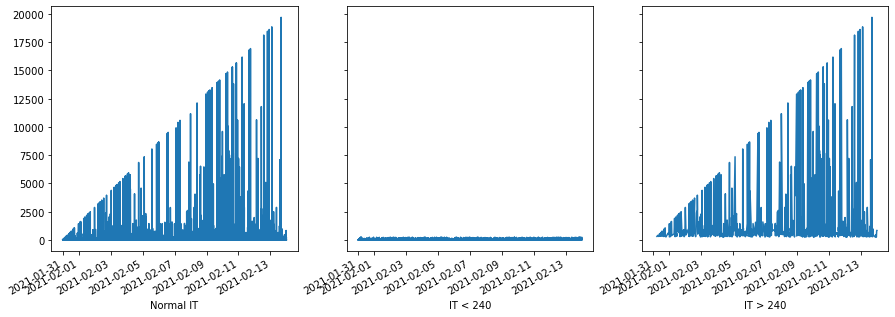

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
ax1.set_xlabel('Normal IT')
ax2.set_xlabel('IT < 240')
ax3.set_xlabel('IT > 240')

ax1.plot(dftest)
ax2.plot(IT_less_than_240)
ax3.plot(IT_more_than_240)

In [ ]:
#Testing for stationarity
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(dftest)

In [75]:
#option 1 - build arima time series model prediction from IT: 0 -> 20000
option1_train = dftest[:594286]
option1_test = dftest[-1386665:]

print('option 1:')
print('actual size: {}\ntrain: {} \ntest: {} \n'.format(dftest.shape,option1_train.shape,option1_test.shape))

#option 2 - build arima time series model prediction from IT > 240 (4 hours)
option2_train = IT_more_than_240[:639]
option2_test = IT_more_than_240[-159:]

print('option 2:')
print('actual size: {}\ntrain: {} \ntest: {}'.format(IT_more_than_240.shape,option2_train.shape,option2_test.shape))

option 1:
actual size: (1980951, 1)
train: (594286, 1) 
test: (1386665, 1) 

option 2:
actual size: (798, 1)
train: (639, 1) 
test: (159, 1)


In [76]:
import pmdarima as pm
model1 = pm.auto_arima(option1_train,stepwise= False, seasonal= False, suppress_warnings= True)
model2 = pm.auto_arima(option2_train,stepwise= False, seasonal= False, suppress_warnings= True)
print(model1)
print(model2)

 ARIMA(5,1,0)(0,0,0)[0] intercept
 ARIMA(2,1,3)(0,0,0)[0] intercept


In [99]:
model.summary()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2021-01-31 05:09:00.012561 to 2021-02-11 13:28:03.582941
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IT      639 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


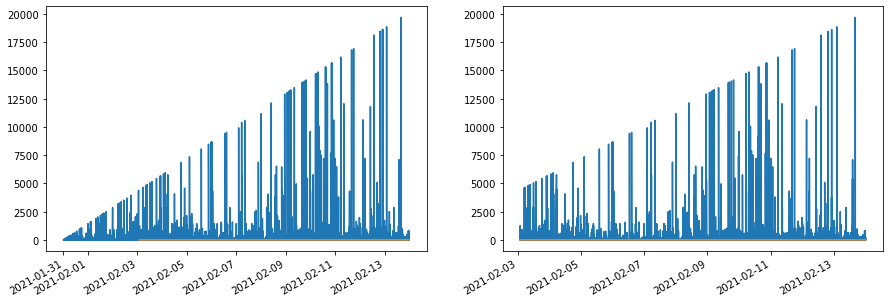

In [83]:
start = len(option1_train)
end = len(option1_train) + len(option1_test) -1
option1_predict = model1.predict(n_periods=len(option1_test))
option1_df = dftest
option1_predict.index = option1_df.index[start:end+1]
option1_df['forecast'] = [None]*len(option1_train) + list(option1_predict)

clearer_image = option1_df.iloc[-1386665:]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')


ax1.plot(option1_df)
ax2.plot(clearer_image)

In [79]:
from sklearn import metrics

print("Mean:",option1_test['IT'].mean())
#print("MSE:",metrics.mean_squared_error(option2_test['IT'],option2_predict))
print("RMSE:",np.sqrt(metrics.mean_squared_error(option1_test['IT'],option1_predict)))

Mean: 1.1712713597011535
RMSE: 90.41110928250536


In [23]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

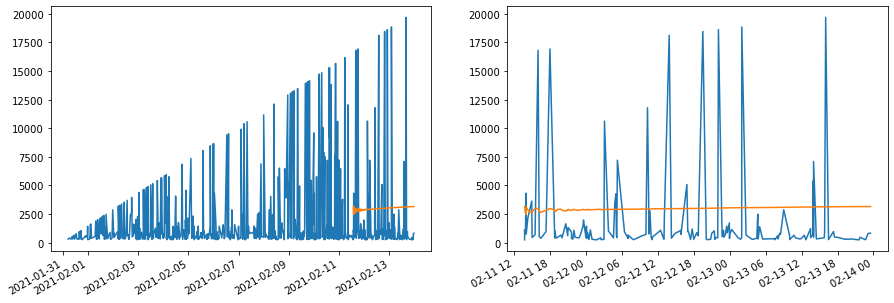

In [77]:
start = len(option2_train)
end = len(option2_train) + len(option2_test) -1
#forecasts = model2.predict(option2_test.shape[0])
option2_predict = model2.predict(n_periods=len(option2_test))
option2_df = IT_more_than_240
option2_predict.index = option2_df.index[start:end+1]
option2_df['forecast'] = [None]*len(option2_train) + list(option2_predict)
#option2_df.plot()

clearer_image = IT_more_than_240.iloc[-159:]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')


ax1.plot(option2_df)
ax2.plot(clearer_image)


In [45]:
from sklearn import metrics

print("Mean:",option2_test['IT'].mean())
#print("MSE:",metrics.mean_squared_error(option2_test['IT'],option2_predict))
print("RMSE:",np.sqrt(metrics.mean_squared_error(option2_test['IT'],option2_predict)))

Mean: 1969.7735849056603
RMSE: 4207.281869019089


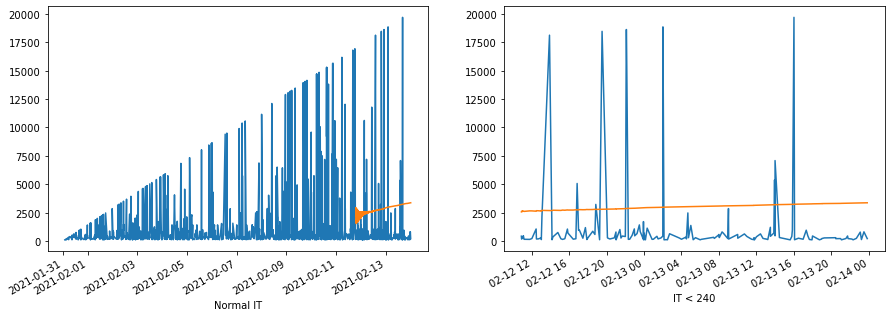

In [68]:
start = len(option2_train)
end = len(option2_train) + len(option2_test) -1
#forecasts = model2.predict(option2_test.shape[0])
option2_predict = model2.predict(n_periods=len(option2_test))
option2_df = IT_more_than_240
option2_predict.index = option2_df.index[start:end+1]
option2_df['forecast'] = [None]*len(option2_train) + list(option2_predict)
#option2_df.plot()

clearer_image = IT_more_than_240.iloc[-159:]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
ax1.set_xlabel('Normal IT')
ax2.set_xlabel('IT < 240')

ax1.plot(option2_df)
ax2.plot(clearer_image)

In [69]:
from sklearn import metrics

print("Mean:",option2_test['IT'].mean())
#print("MSE:",metrics.mean_squared_error(option2_test['IT'],option2_predict))
print("RMSE:",np.sqrt(metrics.mean_squared_error(option2_test['IT'],option2_predict)))

Mean: 1171.2521008403362
RMSE: 3554.7307794752683


In [70]:
model2.predict(5)

955    2214.615493
956    2955.171601
957    1562.362650
958    2305.901644
959    2850.001102
dtype: float64

In [34]:
IT_more_than_240.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 798 entries, 2021-01-31 05:09:00.012561 to 2021-02-13 23:30:00.197834
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IT        798 non-null    float64
 1   forecast  159 non-null    float64
dtypes: float64(2)
memory usage: 18.7 KB


# implementing histogram
- each application is stored in a dictionary as a key
- each key has a list of idle time (IT), with the first position stored as the last invocation time
- histogram will be plotted for every invidual key with bins of 0 to 240 (each bins are of 1mins total 4hour)

In [ ]:
#sample data 1: to reflect incoming invocation call
#sampleTest = trace[['app_id','start_timestamp']].head(100)
sampleTest = trace[['app_id','start_timestamp']]
incoming_invocations = sampleTest.values.tolist()

In [ ]:
incoming_invocations = [['app1', 1], # cold start, new id
['app1', 65], # cold start, IT = 1min, keep alive = current time + 1min
['app1', 130], # cold start, IT = 1min, keep alive 1min = current time + 1min
['app1', 150]] # warm start, 

# how an application will be stored in a dictionary: 
{ 'application1': [datetime.datetime(2023, 3, 12, 2, 0, 22, 60499),  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0], <br>
 'application2': [datetime.datetime(2023, 3, 12, 2, 0, 22, 60499),  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0] }
- key: app_id
- value: list of idle time (IT) for every invocation (first position of the list contains the most recent invocation time)
- first element of the value is the latest function invocation time


# keep_alive_list parameters:
Priority heap queue: [(12.5, "app1"), (100, "app2"), (150, "app3")]
- (keep alive until, application_id)


In [ ]:
# dictionary to store all the app_id
applicationDict = {}
# list to store all the current keep alive application id
keep_alive_list = []

In [ ]:
default_keep_alive_time = 10

# when an incoming function has been invoked
def function_invoked(app_id):
    # application id has not been seen before
    if applicationDict.get(app_id) == None:
        print("NEW app_id: {}".format(app_id))
        result.write("NEW app_id: {} \n".format(app_id))
        applicationDict[app_id] = []
        applicationDict[app_id].append(dt.datetime.now())
        return -1
    
    # application id is already in the dictionary
    else:
        print("OLD app_id: {} ".format(app_id))
        result.write("OLD app_id: {} \n".format(app_id))
        curTime = dt.datetime.now()
        # calculate idle time (IT) by datetime.now - last previous invoked timing
        IT = curTime - applicationDict[app_id][0]
        IT = np.floor(IT.seconds/60)
        print('IDLE TIME (IT) for application: {} is: {} mins'.format(app_id,IT))
        result.write('IDLE TIME (IT) for application: {} is: {} \n'.format(app_id,IT))
        # if the idle time is more than 240mins, return default 10mins as it is out of bounds (OOB)
        if(IT > 240):
            print('application {} is OOB with idle time of: {}'.format(app_id,IT))
            return default_keep_alive_time
        # add the IT into the dictionary and plot the histogram to determine the TTL duration (mins)
        else:
            #print("adding idle time into histogram")
            #result.write("adding idle time into histogram \n")
            applicationDict[app_id].append(IT)
            #update first index of list with the current time
            applicationDict[app_id][0] = curTime
            return plotHistogram(app_id)
            
# hybrid histogram policy
# categorise the histogram into 240 different minutes bins, returning the bin with the highest amount of frequency
# in the event of same frequency, return the lowest number bin
def plotHistogram(app_id):
    appData = applicationDict[app_id][1:]
    print('app_id: {}\'s IT data is: {}'.format(app_id, appData))
    
    # Plot histogram with 240 bins ranging from 0 to 240
    counts, bins, _ = plt.hist(appData, bins=240, range=(0, 240), density=False, edgecolor='black')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Show the plot
    plt.show()
    plt.close()
    print(counts)
    data = counts.tolist()
    #print("highest frequency of minutes bin of the application is: {}".format(data.index(max(data))))
    return data.index(max(data))

def update_heap_element(keep_alive_list, new_time, app_id):
    # Find the index of the element you want to update
    index = next((i for i, (value1, value2) in enumerate(keep_alive_list) if value2 == app_id), None)

    if index is not None:
        # Update the value of the element
        keep_alive_list[index] = (new_time, keep_alive_list[index][1])
        # Rebuild the heap
        hq.heapify(keep_alive_list)
        keep_alive_list.sort()
        print("warm start")
        result.write("warm start \n")
    else:
        hq.heappush(keep_alive_list, (new_time, app_id))
        print("cold start")
        result.write("cold start \n")

# Welford’s online algorithm (CV)
def calculate_CV(app_bins):
    N = len(app_bins)
    M = 0
    S = 0

    for k in range(1, N+1):
        x = app_bins[k-1]
        oldM = M
        M = M + (x - M) / k
        S = S + (x - M) * (x - oldM)
    
    return S / (N - 1)

def addKeepAlive(app_id,TTL):
    return 0

def removeKeepAlive(app_id):
    return 0

def checkKeepAlive():
    return 0

# simulation
in this simulation, we have 2 kinds of timer, difference_timer and delta_timer.
- difference_timer: incrementally increasing in time since the start for time calculation
- delta_timer: printing of simulation's current time (every 1 second)

In [ ]:
import datetime as dt
import time

start_time = dt.datetime.now()
timer = dt.datetime(2021,1,31,0,0,0) # used to output incremental timestamp
timer_temp = dt.datetime.now() # used to check for every second
result = open("result.txt","w") # output logs into a txt file as data is large
stop_time_seconds = 28800 # how long should the program run

while True:
    # accumulating seconds to track to check for incoming functions as well as calculating time to live (TTL)
    difference_timer = dt.datetime.now()-start_time 
    
    #non-incremental timer to check if 1sec has lapsed
    delta_timer = dt.datetime.now()-timer_temp
    
    #print out every second incrementally
    if delta_timer.seconds >= 1:
        timer = timer + dt.timedelta(0,1)
        print(timer.time())
        result.write("{}\n".format(timer.time()))
        timer_temp = dt.datetime.now()
    
    #if still have functions pending invocation
    if len(incoming_invocations) != 0:
        #while(True):
        # since the start_time column is sorted, the first index is always the first to be invoked
        incoming_application_time = dt.timedelta(seconds=incoming_invocations[0][1])
        if(difference_timer >= incoming_application_time):
        
            print("TRIGGERED: application {} has been invoked".format(incoming_invocations[0][0]))
            result.write("TRIGGERED: application {} has been invoked \n".format(incoming_invocations[0][0]))
            # here the return is the histogram output, 10 if OOB, -1 if new function
            keep_alive_time = function_invoked(incoming_invocations[0][0])
            # here we ignore -1 as a new function does not have any frequency
            # we calculate the TTL end time with current simulation time (difference_timer) + returned minute bin
            if(keep_alive_time>0):
                print("keep alive time is: {} mins".format(keep_alive_time))
                result.write("keep alive time is: {} mins \n".format(keep_alive_time))
                alive_timer = difference_timer + dt.timedelta(minutes = keep_alive_time)
                print("keep alive till time: {}".format(alive_timer.total_seconds()))
                #hq.heappush(keep_alive_list,(alive_timer.total_seconds(),incoming_invocations[0][0]))
                update_heap_element(keep_alive_list, alive_timer.total_seconds(), incoming_invocations[0][0])
                print("keep alive list: {}".format(keep_alive_list))
                result.write("keep alive list: {} \n".format(keep_alive_list))
            del incoming_invocations[0]
            
#         else:
#             break
    
    # as long as there is still applications in the TTL list, we will keep checking
    if len(keep_alive_list) != 0:
        # since the TTL list is a heap queue, the first position is always the earliest terminated one
        # so we check if first element is pending expiry, then remove from heap queue
        check_expiry = keep_alive_list[0][0]
        # check if current simulation time has caught up with the application's TTL timing
        if difference_timer.total_seconds() >= check_expiry:
            print("{} container has expired".format(keep_alive_list[0][1]))
            result.write("{} container has expired \n".format(keep_alive_list[0][1]))
            hq.heappop(keep_alive_list)
            print(keep_alive_list)
            result.write("keep alive list: {} \n".format(keep_alive_list))
        #else:
            #print("{} container has NOT expired yet".format(keep_alive_list[0][1]))

    #terminate program if exceeded input time
    if (dt.datetime.now() - start_time).seconds >= stop_time_seconds:
        break
    if (len(incoming_invocations) == 0) and (len(keep_alive_list) == 0):
        break
    time.sleep(0.8)
        
print("==end of run==")
result.write("==end of run==\n")
result.close()

In [ ]:
may28_3hr_dict = applicationDict
may28_3hr_keepalive = keep_alive_list

In [ ]:
may28_3hr_keepalive

In [ ]:
for key,value in may28_3hr_dict.items():
    print(key)

In [ ]:
plotHistogram(a55aa23d7c2a7c801bc9e68afe4c90c86dc0486922e472373cf71865aec598a4)

# test CV

In [ ]:
sample_bin1 = [0] * 240
sample_bin2 = [0] * 240
sample_bin1[1] = 3
sample_bin2[1] = 20

In [ ]:
print("sample_bin1 CV = {}".format(calculate_CV(sample_bin1)))
print("sample_bin2 CV = {}".format(calculate_CV(sample_bin2)))

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

In [ ]:
y